# Exercise 3

## Part I
Write a function to estimate the autocovariance function $\Gamma(\tau)$ with $\tau = (\tau_{\text{min}},\dots,\tau_{\text{max}})$ of a stochastic process and estimate autocovariance function for the residuals (annual cycle and trend removed - see Exercise 1) Hamburg Fuhlsbuettel temperature timeseries.  Calculate biased (Eq.  2.2.7) and unbiased (Eq.  2.2.10) estimators and compare results with implemented function in R or python.  What estimator is given there?  
  
Tip:  
As function in python you can use acovf() from the statsmodels library  
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acovf.html  
import the library with "import statsmodels.api as sm"
To find it you can search in the library via dir(sm)  
To get an overview of how to handel the function you can use help(....acovf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt        

In [2]:


# ---------------------------------------------
# Define autocovariance function
# ---------------------------------------------

def akf(ts,taumin,taumax,unbiased=True):
    ts = np.array(ts)
    N = len(ts)
    ts_mean = np.mean(ts)
    taus = np.arange(taumin,taumax+1)
    C = [((ts[:N-np.abs(tau)]-ts_mean)@(ts[np.abs(tau):]-ts_mean))/(N - unbiased*(np.abs(tau)+1)) for tau in taus] 
    return C,taus


In [3]:
# ------------------------------------------------
# Load nc file
# ------------------------------------------------

import netCDF4 as nc
import datetime
import dateutil

datafile = '/data/KlimDyn1/tHAMBURG-FUHLS.nc'
data = nc.Dataset(datafile)
time = data['time'][:]
temp = data['temp'][:]




In [4]:
# ---------------------------------
# Get residulas
# ---------------------------------

import statsmodels.api as sm

h0 = np.ones(len(time))
h1 = np.linspace(0,1,len(time))
h2 = np.cos((2*np.pi*time[:])/12)
h3 = np.sin((2*np.pi*time[:])/12)
H = np.array([h0,h1,h2,h3]).T


estimate = sm.OLS(temp, sm.add_constant(H)).fit()
residuals = estimate.resid


In [5]:
# ---------------------------------------
# Calculate akf
# ---------------------------------------

Cxx_ub, tau = akf(residuals,-len(residuals)+2,len(residuals)-2,unbiased=True)
Cxx_b, tau = akf(residuals,-len(residuals)+2,len(residuals)-2,unbiased=False)

Cmod_ub = sm.tsa.stattools.acovf(residuals,demean=True,unbiased=True,fft=False)
Cmod_b = sm.tsa.stattools.acovf(residuals,demean=True,unbiased=False,fft=False)

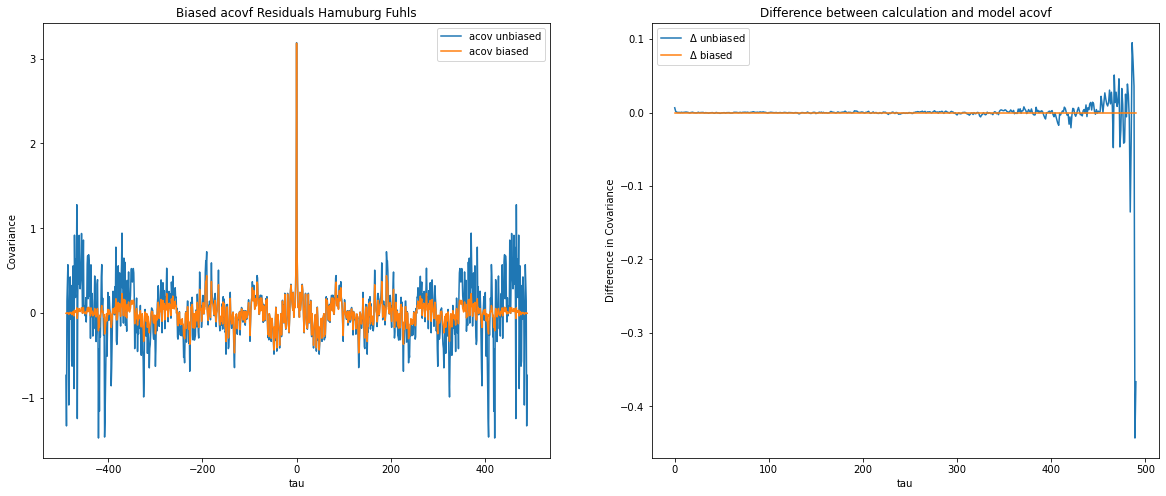

In [6]:
# -------------------------------------------
# Plot acovf and differences of calculation and model results
# -------------------------------------------

import matplotlib.pyplot as plt

diff_ub = Cxx_ub[-len(residuals)+1:] - Cmod_ub[:-1]
diff_b = Cxx_b[-len(residuals)+1:] - Cmod_b[:-1]

fig,axs = plt.subplots(1,2,figsize=(20,8))  
axs[0].plot(tau,Cxx_ub,label='acov unbiased')
axs[0].plot(tau,Cxx_b,label='acov biased')
axs[0].legend()
axs[0].set_title('Biased acovf Residuals Hamuburg Fuhls')
axs[0].set_ylabel('Covariance')

axs[1].plot(diff_ub,label='$\Delta$ unbiased')
axs[1].plot(diff_b,label='$\Delta$ biased')
axs[1].legend()
axs[1].set_title('Difference between calculation and model acovf')
axs[1].set_ylabel('Difference in Covariance')

for ax in axs:
    ax.set_xlabel('tau')

plt.show()

## Part II (Homework)
Estimate the autocovariance function for the process from Exercise II  
  
 $X[t] = \alpha * ( X[t-1]-\mu[t-1] ) + \eta[t] + \mu[t]$  
   
 but without trend and annual cycle, i.e.$\mu(t)=a_0$.  Plot the average and standard deviation. 

### (i)
Generate a sample of processes $X(t)$ and derive estimate the covariancefunction $\hat{\gamma}(\tau)$ for each realization

In [7]:
samples = 1000

a0 = 283.15
mu = 0
sigma = 5
length = 120
alpha = 0.2
times = np.arange(1,121)

a = np.array([a0])
eta = np.random.normal(mu,sigma,length)
seta2 = np.var(eta)

def mu_t(a,time):
    return [a[0] for t in time]
mu_time = mu_t(a,times)

def x_t(alpha, eta, mu_time, time):
    x = np.zeros(len(time))
    x[0] = mu_time[0]
    for i in range(1,len(time)):
        x[i] = alpha * (x[i-1] - mu_time[i-1]) + eta[i] + mu_time[i]
    return x

covM = np.zeros((samples,len(times)))
for s in range(samples):
    eta = np.random.normal(mu,sigma,length)
    x = x_t(alpha,eta,mu_time,times)
    covM[s,:] = sm.tsa.stattools.acovf(x,demean=True,unbiased=False,fft=False)
    


### (ii)
Plot the average over all realizations of $\hat{\gamma}(\tau) $ and the sample uncertainty (i.e.as +−one standard deviation) as a function of $\tau$.  Plot also the theoretical autocovariance function (see Eq.  2.2.26).

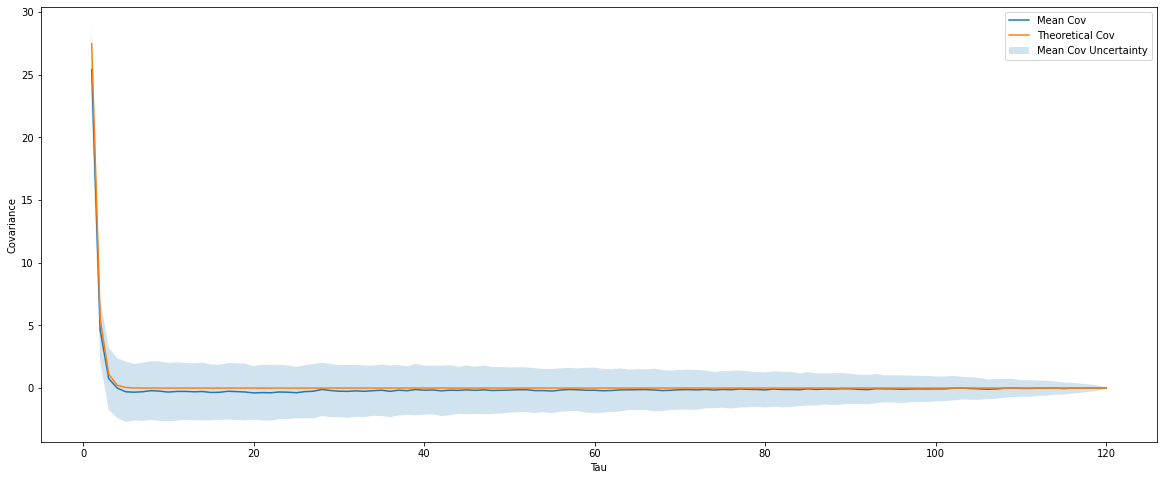

In [8]:
cov_mean = np.zeros(len(times))
cov_std = np.zeros(len(times))

for t in range(len(times)):
    cov_mean[t] = np.mean(covM[:,t])
    cov_std[t] = np.std(covM[:,t])
    
theoretical = [seta2*alpha**tau/(1-alpha**2) for tau in range(len(times))]

fig, ax = plt.subplots(figsize=(20,8))

ax.plot(times,cov_mean,label='Mean Cov')
ax.fill_between(times, cov_mean+cov_std, cov_mean-cov_std, alpha=0.2, label="Mean Cov Uncertainty")
ax.plot(times,theoretical,label='Theoretical Cov')
ax.legend()
ax.set_xlabel('Tau')
ax.set_ylabel('Covariance')
plt.show()